# Final project

##### Author: Kerimbek Raiymbek

### 0. Prepare the datasets

In [1]:
import numpy as np

# Data points
in_dim = 4
X_a = np.random.normal(loc=[1, 1, 1, 1], scale=[0.5, 0.5, 0.5, 0.5], size=(10000, in_dim))
X_b = np.random.normal(loc=[0, 0, 0, 0], scale=[2, 2, 2, 2], size=(10000, in_dim)) 

# Labels 
y_a = np.ones((len(X_a), 1))
y_b = np.zeros((len(X_b), 1))

# Merge and shuffle the data
label = np.concatenate((y_a, y_b))
x = np.concatenate((X_a, X_b))
idx = np.arange(len(x))
np.random.shuffle(idx)
X = x[idx]
label = label[idx]

### 1. Neural network

In [2]:
import torch
import torch.nn as nn
import torch.functional as F
# Create the model of a neural network
class fcn_model(nn.Module):
    def __init__(self, in_dim):
        super(fcn_model, self).__init__()
        self.fc1 = nn.Linear(in_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x) :
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return torch.sigmoid(out)

In [3]:
# Test the model
model = fcn_model(in_dim=4)
out = model(torch.from_numpy(x).float())
print(out.shape)

torch.Size([20000, 1])


### 2. Loss function

The custom loss function consists of the $\text{ Binary Cross Entropy}$ and the mean euclidean distance between $x_i$ data point and $\mu_1$ among all points of input, so I firstly calculated the mean euclidean distance for each point in inputs with the norm() function which returns Euclidean distance and then the BCELoss between output and target and returned sum of two

In [4]:
def loss(output, target, inputs):
    mu_1 = [1, 1, 1, 1]
    mu_1 = torch.FloatTensor(mu_1)
    dis = 0
    for i in inputs:
        dis += torch.norm(i - mu_1, 2)
    dis /= inputs.size(0)
    ans = nn.BCELoss()(output, target)
    return ans + dis

In [5]:
print(loss(out, torch.from_numpy(label).float(), torch.from_numpy(x)))

tensor(3.2740, dtype=torch.float64, grad_fn=<AddBackward0>)


### 3. Data loader

In [6]:
## Data loader
from torch.utils import data

class MyDataset(data.Dataset):
    def __init__(self, X, label):
        self.X = torch.from_numpy(X).float()
        self.label = torch.from_numpy(label).float()
    
    def __getitem__(self, index):
        x = self.X[index]
        y = self.label[index]
        return x, y
    
    def __len__(self):
        return len(self.X)
    
def get_dataloader(X, label, batch_size, test_size=0.2):    

    ## shuffle data
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X, label = X[idx], label[idx]
    
    ## divide data for train and validation
    nb_train = int((1-test_size)*len(X))
    trainset = MyDataset(X[:nb_train], label[:nb_train])
    testset = MyDataset(X[nb_train:], label[nb_train:])
    
    dataloaders = {
        'train':data.DataLoader(trainset, batch_size=batch_size, shuffle=True), 
        'val':data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    }
    return dataloaders

### 4. Train the model function

In [7]:
## build a function to train and val your model
from __future__ import print_function
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs, device):
    since = time.time()
    
    # histroy of training
    history = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[]}
    
    model = model.to(device)
    step_show = 10 ## each i*step_show print current loss
    for epoch in range(num_epochs):
        if (epoch+1) % step_show == 0:
            print('Epoch {0}/{1}'.format(epoch+1, num_epochs))
            
        # training
        model.train()
        running_loss, running_corrects = 0.0, 0.0
        for i, (inputs, target) in enumerate(dataloaders['train']):
            ## put inputs and target to device 
            inputs = inputs.to(device).float()
            target = target.to(device).float()
            
            ## get outputs from the model and compute loss with respect to loss function 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, target, inputs)
            
            ## back prop
            loss.backward()
            optimizer.step()

            ## compute loss and corrects of prediction in each batch of data
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum((outputs+.5).int().t()==target.data.int().t())
            
        ## record loss and corrects of prediction at each epoch
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_corrects = running_corrects.double() / len(dataloaders['train'].dataset)
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_corrects)
        
        ##validate 
        model.eval() #set the module in evaluation mode (eg. Dropout, batchnorm)
        val_running_loss, val_running_corrects = 0.0, 0.0
        for i, (inputs, target) in enumerate(dataloaders['val']):
            inputs = inputs.to(device).float()
            target = target.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, target, inputs)
            
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum((outputs+.5).int().t()==target.data.int().t())
            
        val_epoch_loss = val_running_loss / len(dataloaders['val'].dataset)
        val_epoch_corrects = val_running_corrects.double() / len(dataloaders['val'].dataset)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_corrects)
        
        ## print epoch loss and corrects if its a step to print
        if (epoch + 1)%step_show==0:
            print('Epoch Loss: {0:.6f}, Acc: {1:.6f}, Val Acc: {2:.6f}'
                  .format(epoch_loss, epoch_corrects, val_epoch_corrects))
            print('-'*10)
            
    ## print total time for training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model, history

### 5. Setup parameters and train model

In [8]:
## favourite parameter
batch_size = 256
num_epochs = 50
test_size = 0.2

## assert which device to compute in model
device = torch.device("cpu")
## get your model here 
model = fcn_model(in_dim=in_dim)
## get batched data for train and val
dataloaders = get_dataloader(X=X, label=label, batch_size=batch_size, test_size=test_size)
## Set criterion to our custom loss function
criterion = loss
## Set optimizer to gradient descent
optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999),
                            eps=1e-8,
                            weight_decay=1e-5)


## train your model, get trained model and history of training
model, history = train_model(model=model, 
                             dataloaders=dataloaders, 
                             optimizer=optimizer, 
                             criterion=criterion, 
                             num_epochs=num_epochs, 
                             device=device)

Epoch 10/50
Epoch Loss: 2.647059, Acc: 0.969375, Val Acc: 0.969500
----------
Epoch 20/50
Epoch Loss: 2.637934, Acc: 0.971437, Val Acc: 0.972000
----------
Epoch 30/50
Epoch Loss: 2.635830, Acc: 0.972437, Val Acc: 0.974500
----------
Epoch 40/50
Epoch Loss: 2.634890, Acc: 0.973688, Val Acc: 0.973750
----------
Epoch 50/50
Epoch Loss: 2.634244, Acc: 0.973562, Val Acc: 0.974500
----------
Training complete in 0m 19s


### 6. Training history

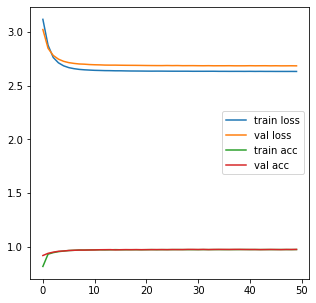

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.plot(history['acc'], label='train acc')
plt.plot(history['val_acc'], label='val acc')
plt.legend(loc='best')
plt.show()

### Save trained model

In [10]:
torch.save(model.state_dict(), 'fcn_model.pt')

### 7. Test our model

In [11]:
## define a test model with a save structure for train
#Load our saved model
test_model = fcn_model(in_dim=in_dim)
test_model.load_state_dict(torch.load('fcn_model.pt'))
# generate new test data
np.random.seed(seed=0)
mu_1 = [1,1,1,1]
mu_2 = [0,0,0,0]
s_1 = [0.5, 0.5, 0.5, 0.5]
s_2 = [2, 2, 2, 2]
sample_size = 2000
a_test = np.random.normal(loc=mu_1, scale=s_1, size=(sample_size, in_dim))
b_test = np.random.normal(loc=mu_2, scale=s_2, size=(sample_size, in_dim))

#### Run the model for new datasets, to obtain predictions from our model.

In [12]:
test_model.eval()
a_out = test_model(torch.from_numpy(a_test).float()).detach().numpy()
b_out = test_model(torch.from_numpy(b_test).float()).detach().numpy()

#### Histogram to display the distribution of the predictoins for test sets.

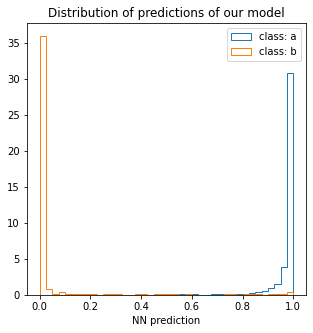

In [13]:
bins = 40
prg = (0, 1)
plt.figure(figsize=(5, 5))
plt.title('Distribution of predictions of our model')
plt.hist(a_out, bins=bins, range=prg, histtype='step', label='class: a', density=True)
plt.hist(b_out, bins=bins, range=prg, histtype='step', label='class: b', density=True)
plt.xlabel('NN prediction')
plt.legend(loc='best')
plt.show()

#### Distance from origin and prediction relation

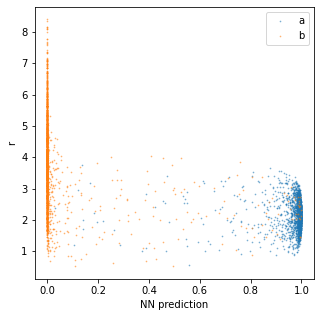

In [14]:
plt.figure(figsize=(5, 5))
plt.scatter(a_out[:,0], np.sqrt(np.sum(np.square(a_test), axis=1)), s=0.5, label='a', alpha=0.5)
plt.scatter(b_out[:,0], np.sqrt(np.sum(np.square(b_test), axis=1)), s=0.5, label='b', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('NN prediction')
plt.ylabel('r')
plt.show()

### 8. Separation method

In [15]:
def separation(a,b):
    # I decided to increase num of bins to get better precision
    num_of_bins = 200
    # 40 bins between 0, 1
    bins = np.linspace(0,1,num_of_bins)
    #Calculate the sum by going through each bin
    sep = 0
    for i in range(num_of_bins - 1):
        #initialize the number of each class in bin
        na = 0
        nb = 0
        #check how many points of class a are within this bin
        for j in a:
            if j >= bins[i] and j < bins[i+1]:
                na += 1
        # Same for class b
        for j in b:
            if j >= bins[i] and j < bins[i+1]:
                nb += 1
        # Calculate separation as in formula, avoided division by 0
        if na+nb != 0:
            sep += (na - nb) ** 2 / (na + nb)
    sep /= 2
    return sep

#### Calculate the separation for our test sample

In [16]:
print('Separation for the test samples: ',separation(a_out, b_out))

Separation for the test samples:  1897.5685774198582
